In [49]:
import time
import sqlite3
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix #conf matrix
import seaborn as sns #conf matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from time import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score

#from utils import mean_absolute_percentage_error

# LOAD DATA

In [50]:
cn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", cn)
df_aux = df
df_aux

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
49015,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
49016,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
49017,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
49018,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


## NEW FEATURES

In [51]:
def parse_score(score):
    w = ''
    if score:
        score = score.split(':')
        if score[0] > score[1]:
            w = 1
        elif score[0] < score[1]:
            w = 2
        elif score[0] == score[1]:
            w = 0
    else:
        w = 'Unknown'
    return w

# Match results
scores = df_aux['score'].values
scores = [x.split(':') if x else [-1, -1] for x in scores]
df_aux['Result'] = df_aux['score'].apply(parse_score)

In [52]:
#Home goals and away goals
home_goals = []
away_goals = []
for scored_goals in scores:
    home_goals.append(scored_goals[0])
    away_goals.append(scored_goals[1])
df_aux['home_goals'] = pd.to_numeric(home_goals)
df_aux['away_goals'] = pd.to_numeric(away_goals)
# Goal difference
df_aux['goal_difference'] = abs(df_aux['home_goals'] - df_aux['away_goals'])
df_aux['total_goals'] = df_aux['home_goals'] + df_aux['away_goals']

In [53]:
#Assigning values to each time in order of aparison
teams = df_aux['home_team'].drop_duplicates().values
df_aux['home_id'] = 0
df_aux['away_id'] = 0
df_aux
for i in range(len(teams)):
    df_aux.loc[df_aux['home_team'] == teams[i], ['home_id']] = i
    df_aux.loc[df_aux['away_team'] == teams[i], ['away_id']] = i

#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['Result'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['date'])
df_aux.reset_index(drop=True, inplace=True) #reset index after droping the unknown

In [54]:
# new columns
df_aux['FHG']= np.nan #Feature home goals (last matches)
df_aux['FAG']= np.nan #Feature away goals (last matches)
df_aux['FTG']= np.nan #Feature total goals (last matches) -> igual mejor no
df_aux['FDG']= np.nan #Feature difference goals (last matches)
df_aux['VHT']= np.nan #victories home team ( last matches)
df_aux['VAT']= np.nan #victories away team ( last matches)

In [55]:
def fix_date(date): 
    if date.year > 2021:
        year = date.year - 100
    else:
        year = date.year
    return datetime.date(int(year),date.month,date.day)
#change date format
df_aux['date'] = pd.to_datetime(df_aux['date']).dt.date
#fix date
df_aux['date'] = df_aux['date'].apply(fix_date)
print(df_aux)

          season  division  matchday        date      time        home_team  \
0      1928-1929         1         1  1929-02-10      None      Arenas Club   
1      1928-1929         1         1  1929-02-10      None         Espanyol   
2      1928-1929         1         1  1929-02-10      None      Real Madrid   
3      1928-1929         1         1  1929-02-10      None         Donostia   
4      1928-1929         1         1  1929-02-12      None           Racing   
...          ...       ...       ...         ...       ...              ...   
48235  2021-2022         2         3  2021-08-28  10:00 PM     Ponferradina   
48236  2021-2022         2         3  2021-08-29   5:00 PM    SD Amorebieta   
48237  2021-2022         2         3  2021-08-29   7:30 PM          CD Lugo   
48238  2021-2022         2         3  2021-08-29   7:30 PM  Real Sociedad B   
48239  2021-2022         2         3  2021-08-29  10:00 PM        Burgos CF   

             away_team score Result  home_goals  ..

In [56]:
def last_matches(df,index,num):
    #variables
    h_t = df['home_id'][index]
    a_t = df['away_id'][index]
    date = df['date'][index]

    #get direct matches
    matches = df[((df['home_id']== h_t) & (df['away_id'] == a_t ))]
    #get last matches of direct matches
    last_matches = matches[matches['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    return last_matches

In [57]:

def tot(df,row,num):
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']
    #get direct matches
    matches = df[((df['home_id']== h_t) & (df['away_id'] == a_t ))]
    #get last matches of direct matches
    last_matches = matches[matches['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    if (last_matches.empty==False):
    #column of total goals, away goals, home goals, diference goals
        home_goals = last_matches['home_goals'].sum()
        away_goals = last_matches['away_goals'].sum()             
        total_goals = last_matches['total_goals'].sum()
        diff_goals = last_matches['goal_difference'].sum()
        vic_home= (last_matches['Result'] == 1).sum(axis=0)
        vic_away= (last_matches['Result'] == 2).sum(axis=0)
        
        row['FHG'] = int(home_goals)
        row['FAG'] = int(away_goals)
        row['FTG'] = int(total_goals)
        row['FDG'] = int(diff_goals)
        row['VHT'] = int(vic_home)
        row['VAT'] = int(vic_away)
    return row
    

In [58]:
num=10
#df_aux= df_aux.iloc[0:20000,:]
df_aux= df_aux.apply(lambda row: tot(df_aux, row,num),axis=1)

In [59]:
#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG'])
df_aux.reset_index(drop=True, inplace=True) #reset index after droping the unknown
df_aux['FHG']=df_aux['FHG'].astype('int')
df_aux['FAG']=df_aux['FAG'].astype('int')
df_aux['FTG']=df_aux['FTG'].astype('int')
df_aux['FDG']=df_aux['FDG'].astype('int')
df_aux['VHT']=df_aux['VHT'].astype('int')
df_aux['VAT']=df_aux['VAT'].astype('int')
print(df_aux)

          season  division  matchday        date      time        home_team  \
0      1929-1930         1         1  1929-12-01      None  Athletic Madrid   
1      1929-1930         1         1  1929-12-01      None         Athletic   
2      1929-1930         1         1  1929-12-01      None        Barcelona   
3      1929-1930         1         1  1929-12-01      None           Racing   
4      1929-1930         1         1  1929-12-01      None       Real Unión   
...          ...       ...       ...         ...       ...              ...   
40066  2021-2022         2         3  2021-08-28   5:00 PM   Sporting Gijón   
40067  2021-2022         2         3  2021-08-28   7:30 PM      Real Oviedo   
40068  2021-2022         2         3  2021-08-28  10:00 PM     Ponferradina   
40069  2021-2022         2         3  2021-08-29   7:30 PM          CD Lugo   
40070  2021-2022         2         3  2021-08-29  10:00 PM        Burgos CF   

             away_team score  Result  home_goals  .

## Chi-Square Test for Feature Selection 


 The chi-square test helps you to solve the problem in feature selection.In feature selection, we need to determine the relationship between the independent category feature (predictor) and dependent category feature(response) as we aim to select the features which are highly dependent on the response.

In [60]:
#from sklearn import datasets
#from sklearn.feature_selection import chi2
#from sklearn.feature_selection import SelectKBest

# Loading wine data
#y= df_aux['Result'].astype('int')
#X= df_aux[['goal_difference','total_goals','home_id','away_id','home_goals','away_goals']].astype('int')
# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
#chi_scores= chi2(X, y)
#print(chi_scores)
#p_values = pd.Series(chi_scores[1],index = X.columns)
#p_values.sort_values(ascending = False , inplace = True)
#p=chi_scores[1]
#print(p[0])
#p_values.plot.bar()

## Pearson correlation

We calculate the absolute value of the Pearson's correlation between the target and features. We keep the top n features based on this criterion.

In [87]:
y= df_aux['Result'].astype('int')
features=['FHG','FAG','FTG','FDG','VHT','VAT']
X= df_aux[features].astype('int')
num_features= 2

In [88]:
def Pearson_select(X, y,num_features):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation for each feature
    for i in feature_name:
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # feature name
    feature_selection = X.iloc[:,np.argsort(np.abs(cor_list))[-num_features:]].columns.tolist()
    # feature selection
    cor_support = [True if i in feature_selection else False for i in feature_name]
    return cor_list, feature_selection

cor_list, feature_selection = Pearson_select(X, y,num_features)
print('features selected:',feature_selection)
print('correlations of features:',cor_list)

features selected: ['FAG', 'VAT']
correlations of features: [-0.011771652442111586, 0.03820261942683145, 0.00753660225494371, 0.00033154465422523483, -0.02370882990027173, 0.04843574152433962]


# SPLIT DATA TRAIN AND TEST

In [63]:
features = ['FTG','FAG','VAT']
target = 'Result'
X = df_aux[features]
y = df_aux[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (32056, 3)
X_test shape: (8015, 3)
y_train shape: (32056,)
y_test shape: (8015,)


In [64]:
### Sin esto da problemas model.fit 

In [65]:
X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# TRAIN AND TEST

In [66]:
def train_test(model, X_train, y_train, X_test, y_test):
    from sklearn import metrics
    #TRAIN
    start = time()
    model.fit(X_train, y_train)
    end = time()
    t = end-start
    print("The model has been trained in {:2f} seconds".format(t))
    
    #PREDICTIONS
    start = time()
    y_pred = model.predict(X_test)
    end = time()
    t = end-start
    print("The predictions have been made in {:2f} seconds".format(t))
    
    labels = ['Tie', 'Home win', 'Away Win']
    #metrics
    print(metrics.classification_report(y_test, y_pred, target_names=labels))
    print("F1 Score: ", metrics.f1_score(y_test, y_pred, average='macro'))
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("Recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_pred, average='macro'))
    
    return y_pred
    

# MODELS

### Linear model --> it doesn't work well

In [67]:
#lm = LinearRegression(fit_intercept=True)

In [68]:
#print("Linear model:")
#y_pred = train_test(lm, X_train, y_train, X_test, y_test)

### Logistic Regression

EN LOGISTIC REGRESSION PUEDES USAR CLASS_WEIGHT= "BALANCED"-> para unbalanced classes

In [69]:
lr = LogisticRegression(multi_class='ovr', max_iter=500,class_weight="balanced")

In [70]:
print("Logistic Regression:")
y_pred_lr = train_test(lr, X_train, y_train, X_test, y_test)

Logistic Regression:
The model has been trained in 0.107845 seconds
The predictions have been made in 0.000000 seconds
              precision    recall  f1-score   support

         Tie       0.27      0.19      0.22      2124
    Home win       0.58      0.50      0.54      4173
    Away Win       0.27      0.47      0.34      1718

    accuracy                           0.41      8015
   macro avg       0.37      0.38      0.37      8015
weighted avg       0.43      0.41      0.41      8015

F1 Score:  0.36664893782894653
Accuracy:  0.40885839051777917
Recall:  0.38458081301184405
Precision:  0.37372767498130915


In [89]:
lr = LogisticRegression(multi_class='ovr', max_iter=500)

In [90]:
print("Logistic Regression:")
y_pred_lr = train_test(lr, X_train, y_train, X_test, y_test)

Logistic Regression:
The model has been trained in 0.131731 seconds
The predictions have been made in 0.000000 seconds
              precision    recall  f1-score   support

         Tie       0.00      0.00      0.00      2124
    Home win       0.53      0.97      0.69      4173
    Away Win       0.42      0.08      0.13      1718

    accuracy                           0.52      8015
   macro avg       0.31      0.35      0.27      8015
weighted avg       0.36      0.52      0.38      8015

F1 Score:  0.2721744667303407
Accuracy:  0.5238927011852776
Recall:  0.3507056701055374
Precision:  0.31485050403434706


###  Random Forest

In [71]:
rf = RandomForestClassifier(class_weight="balanced")

In [72]:
print("Random Forest:")
y_pred_rf = train_test(rf, X_train, y_train, X_test, y_test)

Random Forest:
The model has been trained in 0.990344 seconds
The predictions have been made in 0.119887 seconds
              precision    recall  f1-score   support

         Tie       0.27      0.28      0.27      2124
    Home win       0.56      0.46      0.50      4173
    Away Win       0.25      0.34      0.29      1718

    accuracy                           0.39      8015
   macro avg       0.36      0.36      0.35      8015
weighted avg       0.42      0.39      0.40      8015

F1 Score:  0.3549591576228235
Accuracy:  0.3860262008733624
Recall:  0.3600771929696925
Precision:  0.35851562104896884


###  Decision tree classifier

In [73]:
dt = DecisionTreeClassifier()

In [74]:
print(" Decision tree classifier:")
y_pred_dt = train_test(dt, X_train, y_train, X_test, y_test)

 Decision tree classifier:
The model has been trained in 0.016808 seconds
The predictions have been made in 0.000000 seconds
              precision    recall  f1-score   support

         Tie       0.24      0.07      0.11      2124
    Home win       0.53      0.89      0.66      4173
    Away Win       0.30      0.07      0.11      1718

    accuracy                           0.50      8015
   macro avg       0.36      0.34      0.30      8015
weighted avg       0.40      0.50      0.40      8015

F1 Score:  0.2953408002267247
Accuracy:  0.495321272613849
Recall:  0.3424540806640534
Precision:  0.3586616451211346


### Gaussain Naive Bayes

In [75]:
gnb= GaussianNB()

In [76]:
print(" Gaussain Naive Bayes:")
y_pred_gnb = train_test(gnb, X_train, y_train, X_test, y_test)

 Gaussain Naive Bayes:
The model has been trained in 0.010218 seconds
The predictions have been made in 0.001971 seconds
              precision    recall  f1-score   support

         Tie       0.00      0.00      0.00      2124
    Home win       0.53      0.92      0.68      4173
    Away Win       0.32      0.15      0.20      1718

    accuracy                           0.51      8015
   macro avg       0.29      0.36      0.29      8015
weighted avg       0.35      0.51      0.40      8015

F1 Score:  0.29308577878040665
Accuracy:  0.5124142233312539
Recall:  0.35716844273305276
Precision:  0.2853111996846393


### Multinomial Naive Bayes

In [77]:
mnb= MultinomialNB()

In [78]:
print(" Gaussain Naive Bayes:")
y_pred_mbn = train_test(mnb, X_train, y_train, X_test, y_test)

 Gaussain Naive Bayes:
The model has been trained in 0.006165 seconds
The predictions have been made in 0.000995 seconds
              precision    recall  f1-score   support

         Tie       0.00      0.00      0.00      2124
    Home win       0.54      0.93      0.68      4173
    Away Win       0.34      0.16      0.22      1718

    accuracy                           0.52      8015
   macro avg       0.29      0.36      0.30      8015
weighted avg       0.35      0.52      0.40      8015

F1 Score:  0.2988706620793184
Accuracy:  0.516406737367436
Recall:  0.3620074669273368
Precision:  0.29125033932635885


###  Support Vector Classification --> takes a long time

In [79]:
# svc_rbf = SVC(random_state=100, kernel='rbf')

In [80]:
#print("Support Vector Classification (Radial Basis Function):")
#train_test(svc_rbf, X_train, y_train, X_test, y_test)

# where does it fail the most

You can change the model plot just changing the name of y_pred to see how the model behaves.

General behavour: Most models predict home_team wins better than away_team wins. Ties are very poorly predicted for all models.

## Confusion_matrix

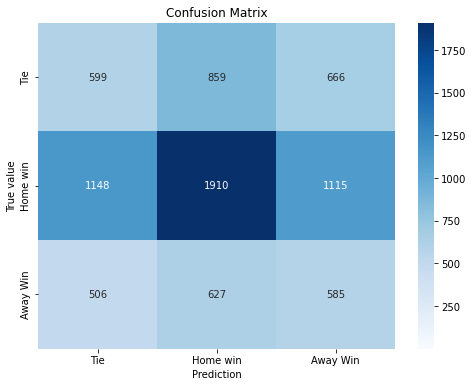

In [81]:
#Print Confusion Matrix
## PONER EN Y_pred el modelo que quieres!!
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Tie', 'Home win', 'Away Win']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2)
plt.title('Confusion Matrix')
plt.ylabel('True value')
plt.xlabel('Prediction')
plt.show()

## True result, well prediction, bad pred

In [82]:
index= X_test.index
df_pred= df_aux.loc[index]
df_pred['prediction'] = y_pred_lr
columns= ['season','division','matchday','date','home_team','away_team','Result','prediction']
df_pred= df_pred[columns]

In [83]:
result = df_pred['Result'].value_counts()
pred= df_pred[['prediction','Result']]
good_pred= pred[pred['prediction'] == pred['Result']].value_counts()
good_pred.reset_index(drop=True, inplace=True, level='Result')

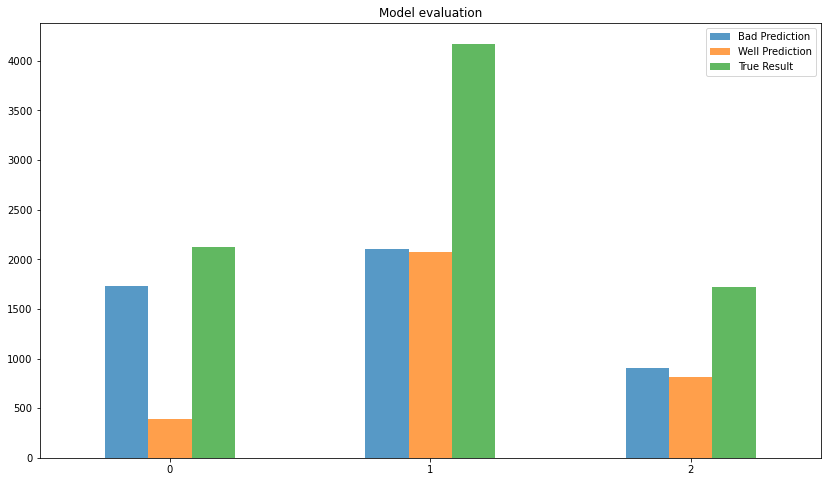

In [84]:
bad_pred= pred[(pred['prediction'] != pred['Result'])].groupby('Result').count()
bad_pred= bad_pred['prediction']
evaluation= pd.concat([bad_pred, good_pred,result], axis=1, keys=['Bad Prediction','Well Prediction','True Result']).plot(kind='bar',
            figsize=(14,8),
            title="Model evaluation",alpha=0.75, rot=0)


## Analysis of failures and successes

Result        0     1    2
prediction                
0           394   769  315
1           891  2073  593
2           839  1331  810


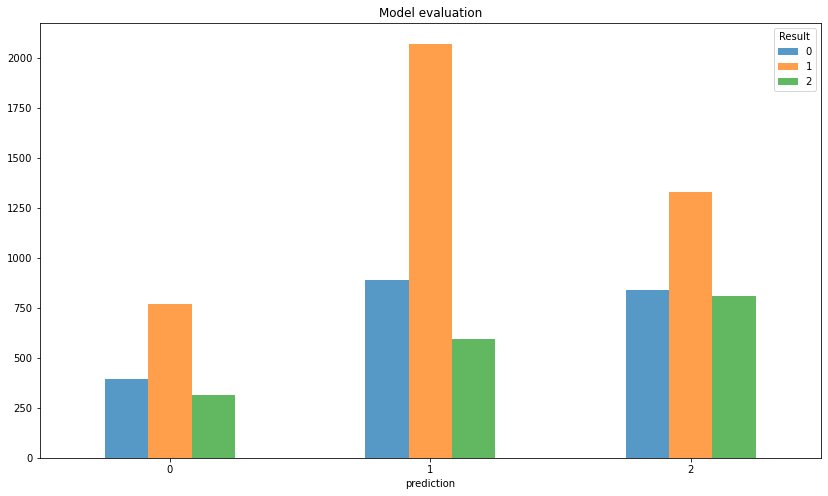

In [85]:
fail_suc= pred[(pred['prediction'] != pred['Result']) | (pred['prediction'] == pred['Result']) ].value_counts()
fail_suc= pd.DataFrame(fail_suc)
fail_suc = fail_suc.unstack()
fail_suc[0].plot(kind='bar',
            figsize=(14,8),
            title="Model evaluation",alpha=0.75, rot=0)

print(fail_suc[0])


# EXPORT MODEL

This only exports the last model run and the TEST

In [86]:
#Replace 0 with X
df_pred[['Result','prediction']] = df_pred[['Result','prediction']].astype(str) 
df_pred[['Result','prediction']]= df_pred[['Result','prediction']].replace('0','X')

shouldExport = input('Do you want to export the model(s) (y / n) ? ')
if shouldExport.strip().lower() == 'y':
    df_pred.to_excel("../models/Predictions.xlsx")